# Beamline Analyzer
### Uses G4Beamline "simple" files as input

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

In [3]:
_save_dir = 'plots/lariat_off_JGG_on/T2/'

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

In [4]:
# config05_2, better JGG with field
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config05_2/merged_sim_arcs_beamline_simple_9858of30k.root'
# n_pions = 9858 * 30000
# config = 'config05_2'

# config07_1, BFIELD=0
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/config07_1/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# f = '/Users/mdeltutt/OneDrive - Fermi National Accelerator Laboratory/Work/ArCS/beamline/files/merged_sim_arcs_beamline_simple_9511of30k_config07_1.root'
# n_pions = 9511 * 30000
# config = 'config07_1'

# config08_1, BFIELD=0, cryo and LAr
f = '/pnfs/lariat/persistent/users/gcicogna/BeamLineSimOutputs/pos60Amps/config09_1/merged_sim_arcs_beamline_simple_first5000.root'

n_pions = 5000 * 30000
config = 'config09'
det_list = ['DetT2', 'Det7', 'JGGDet1']


In [5]:
file = uproot.open(f)
print('Detectors:', file.keys())

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


Detectors: ['VirtualDetector;1', 'VirtualDetector/Det4;1', 'VirtualDetector/Det7;1', 'VirtualDetector/DetT1;1', 'VirtualDetector/DetT2;1', 'VirtualDetector/JGGDet1;1', 'VirtualDetector/JGGDet2;1', 'VirtualDetector/JGGDet3;1']
Number of pions: 150000000
Number of spills: 600.0
Number of hours: 10.0
Number of months: 0.01388888888888889


In [6]:
print('TTree variables:', file[f'VirtualDetector/JGGDet1'].keys())
print('Number of entries in Det4:', file[f'VirtualDetector/Det4'].num_entries)
print('Number of entries in DetT1:', file[f'VirtualDetector/DetT1'].num_entries)
print('Number of entries in DetT2:', file[f'VirtualDetector/DetT2'].num_entries)
print('Number of entries in Det7:', file[f'VirtualDetector/Det7'].num_entries)
print('Number of entries in JGGDet1:', file[f'VirtualDetector/JGGDet1'].num_entries)

TTree variables: ['x', 'y', 'z', 'Px', 'Py', 'Pz', 't', 'PDGid', 'EventID', 'TrackID', 'ParentID', 'Weight']
Number of entries in Det4: 254388
Number of entries in DetT1: 47847990
Number of entries in DetT2: 14243322
Number of entries in Det7: 13515522
Number of entries in JGGDet1: 29372513


In [7]:
def add_vars_to_df(df):
    '''
    Adds total momentum, as well as theta and phi, to the dataframe
    '''

    px = df['Px'].values
    py = df['Py'].values
    pz = df['Pz'].values

    p = np.sqrt(px**2 + py**2 + pz**2)
    theta = np.arccos(pz / p) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180

    df['P'] = p
    df['theta'] = theta
    df['phi'] = phi

    return df


In [8]:
branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

dfs = {} # dictionary to store dataframes, list accessible by detector name

#reading data from .root file

#dfs['DetT1'] = file[f'VirtualDetector/DetT1'].arrays(branches, library='pd')
dfs['DetT2'] = file[f'VirtualDetector/DetT2'].arrays(branches, library='pd')
dfs['Det7'] = file[f'VirtualDetector/Det7'].arrays(branches, library='pd')
dfs['JGGDet1'] = file[f'VirtualDetector/JGGDet1'].arrays(branches, library='pd')

#removing duplicates
#dfs['DetT1'] = dfs['DetT1'].drop_duplicates(['EventID', 'TrackID'])
dfs['DetT2'] = dfs['DetT2'].drop_duplicates(['EventID', 'TrackID'])
dfs['Det7'] = dfs['Det7'].drop_duplicates(['EventID', 'TrackID'])
dfs['JGGDet1'] = dfs['JGGDet1'].drop_duplicates(['EventID', 'TrackID'])

#adding total momentum, theta and phi to the dataframes
#dfs['DetT1'] = add_vars_to_df(dfs['DetT1'])
dfs['DetT2'] = add_vars_to_df(dfs['DetT2'])
dfs['Det7'] = add_vars_to_df(dfs['Det7'])
dfs['JGGDet1'] = add_vars_to_df(dfs['JGGDet1'])

# print(dfs['DetT1'])
# print(dfs['JGGDet1'])

# df2.loc[(df2['EventID'] == 29970112.0) & (df2['TrackID'] == 121664.0)]

## Merge TTrees

Merging TTrees for 4 detectors.

First merge: DetT1 and DetT2.
Second merge: (first) and Det7.
Third merge: (second) and JGGDet1.

The goal is to keep particles that are present in the 4 detectors [DetT1, DetT2, Det7, JGGDet1], to select particles to trigger on.

The detectors are on-axis with the beam; JGG is ON, LArIAT magnets are OFF.

In [9]:
#First Merge: DetT1 and DetT2 -----------------------------------------------------------------------------------------------------
#df_merged1 = dfs['DetT1'].merge(dfs['DetT2'], on=['EventID', 'TrackID'], how='left', indicator=True, suffixes=('_DetT1', '_DetT2'))

#Drop particles that are not in both detectors
#df_merged1 = df_merged1[df_merged1['_merge'] == 'both']

#Drop PDGid columns (redundant)
#df_merged1 = df_merged1.drop(['PDGid_DetT1'], axis=1)

#Rename PDGid column
#df_merged1 = df_merged1.rename(columns={'PDGid_DetT2': 'PDGid'})

#Second Merge: DetT1+DetT2 (df_merged1) and Det7 -----------------------------------------------------------------------------------------------------
df_merged2 = dfs['DetT2'].merge(dfs['Det7'], on=['EventID', 'TrackID'], how='left', indicator='_merge1', suffixes=('_DetT2', '_Det7'))
df_merged2 = df_merged2[df_merged2['_merge1'] == 'both']
df_merged2 = df_merged2.drop(['PDGid_Det7'], axis=1)

#Third Merge: DetT1+DetT2+Det7 (df_merged2) and JGGDet1 -----------------------------------------------------------------------------------------------------
df = df_merged2.merge(dfs['JGGDet1'], on=['EventID', 'TrackID'], how='left', indicator='_merge_final', suffixes=('_merge1', '_JGGDet1'))
df = df[df['_merge_final'] == 'both']
df = df.drop(['PDGid_JGGDet1'], axis=1, errors='ignore')

df = df.rename(columns={'x':'x_JGGDet1',
                        'y':'y_JGGDet1',
                        'z':'z_JGGDet1',
                        'Px':'Px_JGGDet1', 
                        'Py':'Py_JGGDet1', 
                        'Pz':'Pz_JGGDet1', 
                        'P':'P_JGGDet1', 
                        'theta':'theta_JGGDet1', 
                        'phi':'phi_JGGDet1'})

print(df.columns)


Index(['x_DetT2', 'y_DetT2', 'z_DetT2', 'Px_DetT2', 'Py_DetT2', 'Pz_DetT2',
       'PDGid_DetT2', 'EventID', 'TrackID', 'P_DetT2', 'theta_DetT2',
       'phi_DetT2', 'x_Det7', 'y_Det7', 'z_Det7', 'Px_Det7', 'Py_Det7',
       'Pz_Det7', 'P_Det7', 'theta_Det7', 'phi_Det7', '_merge1', 'x_JGGDet1',
       'y_JGGDet1', 'z_JGGDet1', 'Px_JGGDet1', 'Py_JGGDet1', 'Pz_JGGDet1',
       'PDGid', 'P_JGGDet1', 'theta_JGGDet1', 'phi_JGGDet1', '_merge_final'],
      dtype='object')


In [10]:
# df.query('PDGid==11 and P_Det7 < 100 and theta_Det7 < 10')

In [11]:
def get_values_labels(df, det='JGGDet1', variable='p', p_cut=80):
    '''
    Returns values to plot with their labels

    Args:
        det (str): the detector to plot
        variable (str): the variable to plot
        p_cut (int): momentum cut
    '''

    # Apply a momentum cut
    df_ = df.query(f'P_{det} > {p_cut}')

    # if det == 'Det7':
    #     df_ = df_.query(f'theta_{det} < 1')

    pdg = df_['PDGid'].values

    if variable == 'p':
        var = df_[f'P_{det}'].values
    elif variable == 'theta':
        var = df_[f'theta_{det}'].values
    elif variable == 'phi':
        var = df_[f'phi_{det}'].values
        
    kaons = var[np.abs(pdg)==321]
    positrons = var[pdg==-11]
    electrons = var[pdg==+11]
    muons = var[np.abs(pdg)==13]
    protons = var[np.abs(pdg)==2212]
    pions = var[np.abs(pdg)==211]
    others = var[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    gamma = var[np.abs(pdg)==22]
    
    values = [
        # others,
        # gamma,
        kaons,
        positrons,
        electrons,
        muons,
        protons,
        pions,
    ]

    tot = len(kaons) + len(electrons) + len(positrons) + len(muons) + len(protons) + len(pions)
    # tot += len(others)
    # tot += len(gamma)
    
    labels = [
        # 'others' + f', ({len(others) / tot * 100:.1f}%)',
        # 'gamma' + f', ({len(gamma) / tot * 100:.1f}%)',
        r'$K^\pm$' + f', ({len(kaons):.2e}, {len(kaons) / tot * 100:.1f}%)',
        r'$e^+$' + f', ({len(positrons):.2e}, {len(positrons) / tot * 100:.1f}%)',
        r'$e^-$' + f', ({len(electrons):.2e}, {len(electrons) / tot * 100:.1f}%)',
        r'$\mu^\pm$' + f', ({len(muons):.2e}, {len(muons) / tot * 100:.1f}%)',
        r'$p^\pm$' + f', ({len(protons):.2e}, {len(protons) / tot * 100:.1f}%)',
        r'$\pi^\pm$' + f', ({len(pions):.2e}, {len(pions) / tot * 100:.1f}%)'
    ]

    return values, labels

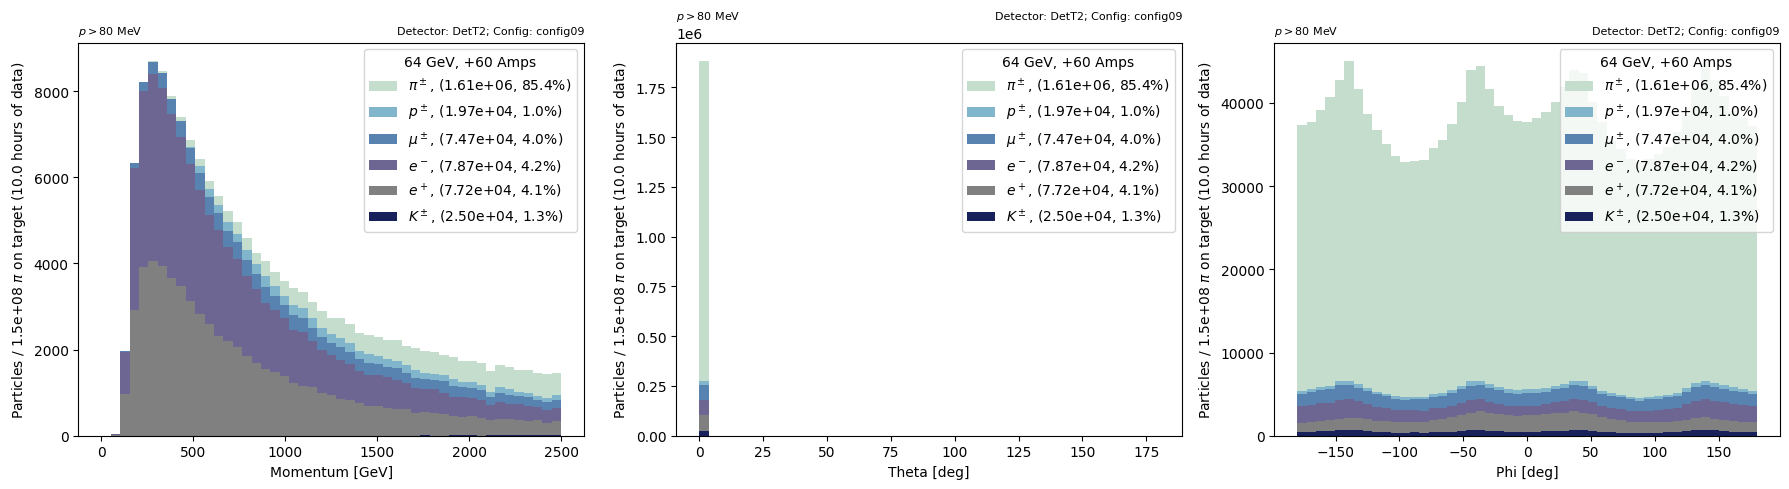

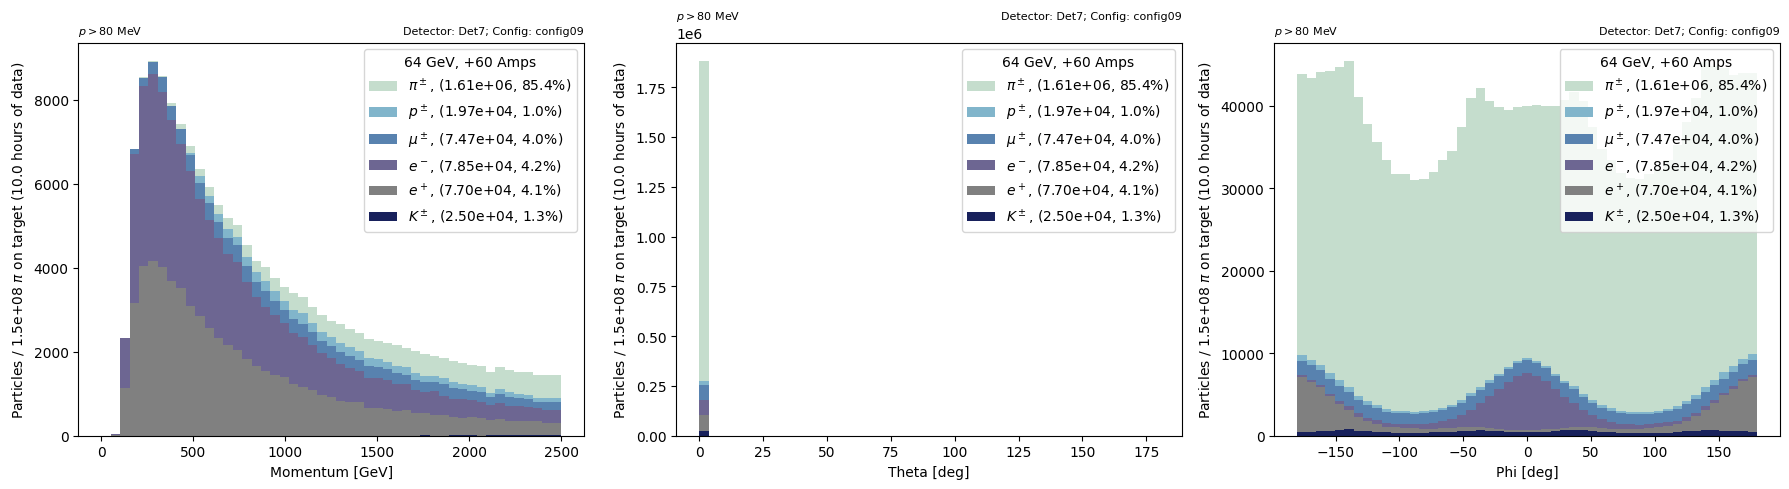

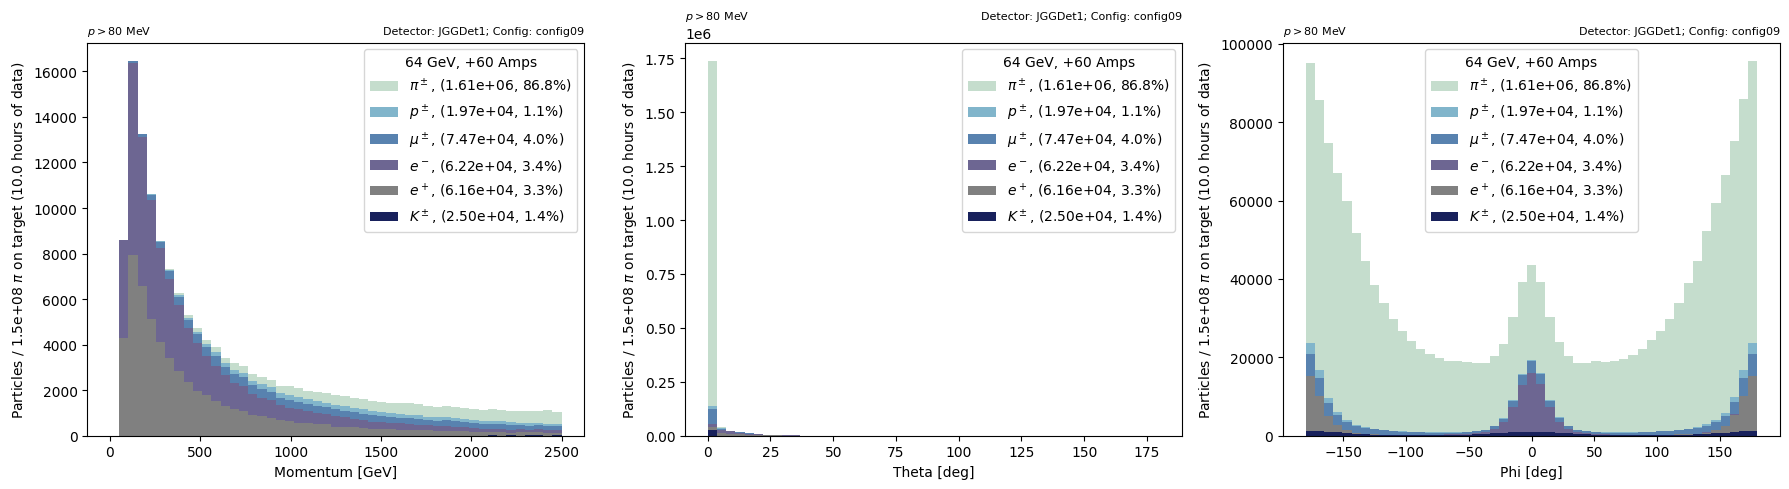

In [12]:
for det in det_list:

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    x_axis = {'p': 'Momentum [GeV]',
              'theta': 'Theta [deg]',
              'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50),
              'theta': np.linspace(0, 180, 50),
              'phi': np.linspace(-180, 180, 50)}

    for i, variable in enumerate(['p', 'theta', 'phi']):

        p_cut = 80

        values, labels = get_values_labels(df, det, variable, p_cut)
    
        bins = x_bins[variable]
        
        ax[i].hist(values, bins=bins, color=colors, label=labels, stacked=True)
        
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)
    
        ax[i].set_xlabel(x_axis[variable])
        ax[i].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)' )
        ax[i].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
        ax[i].set_title(f'$p>{p_cut}$ MeV', loc='left', fontsize=8)
        
        # if det == 'Det7' or det == 'Det8' or 'JGG' in det:
        #     ax[i].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()


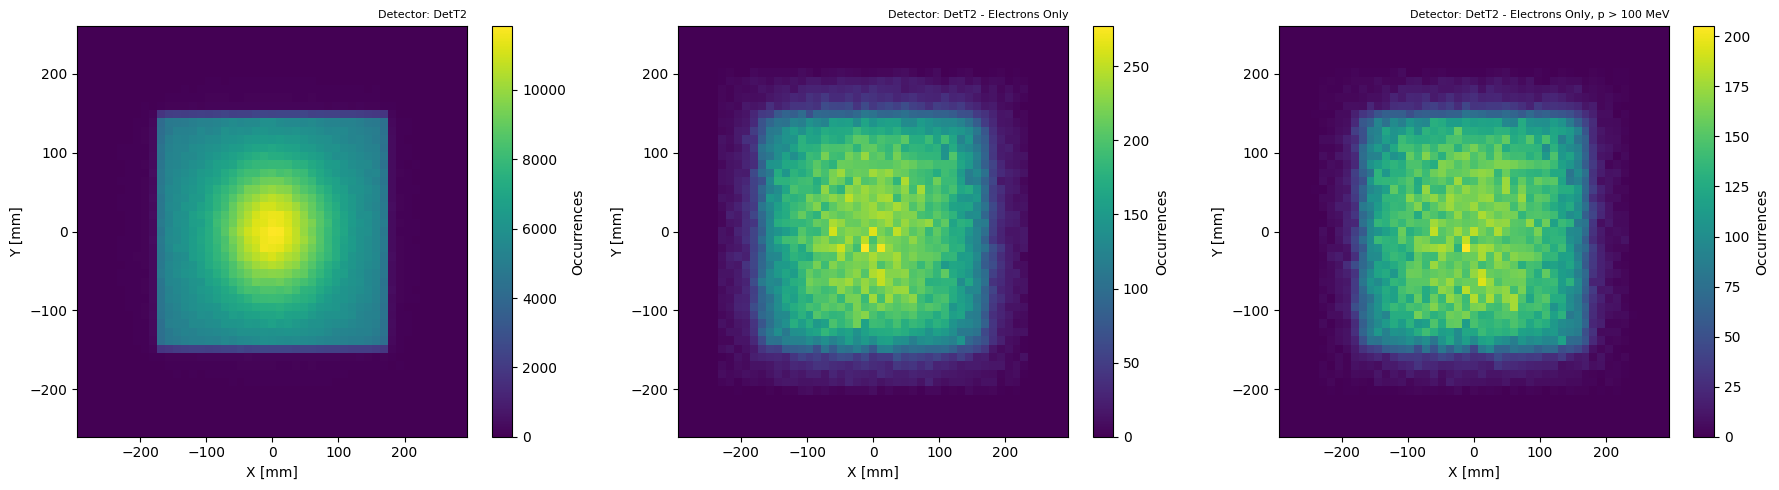

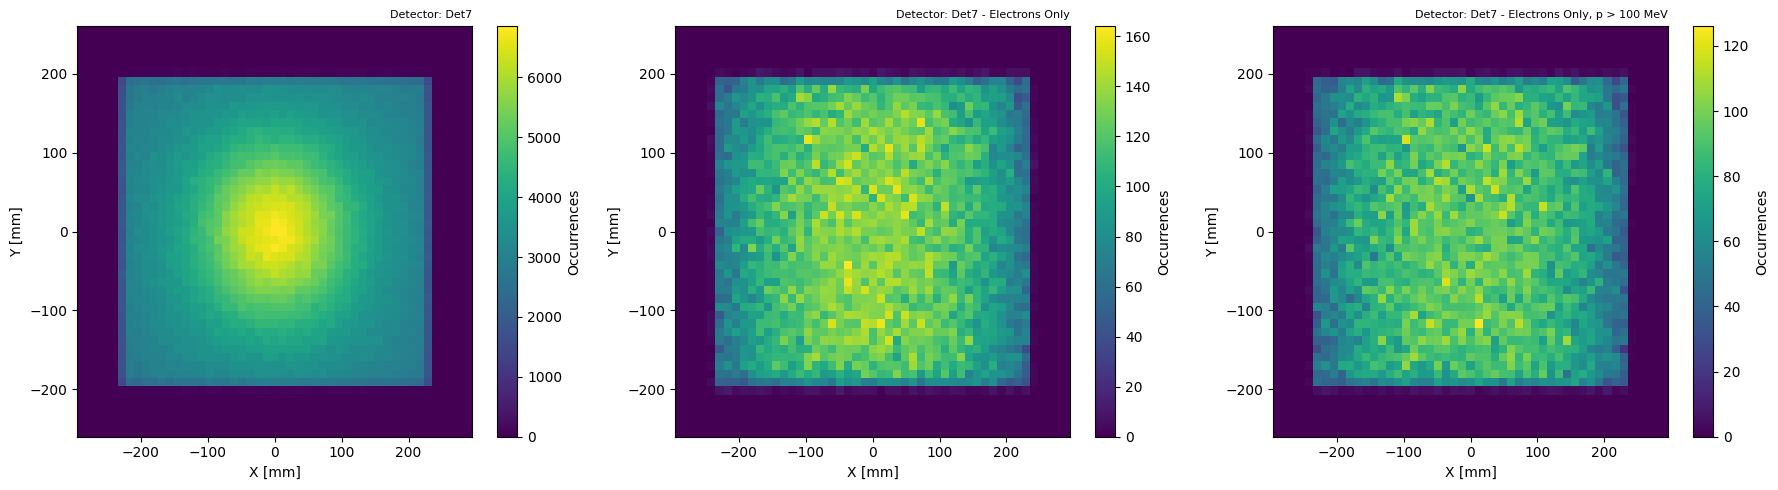

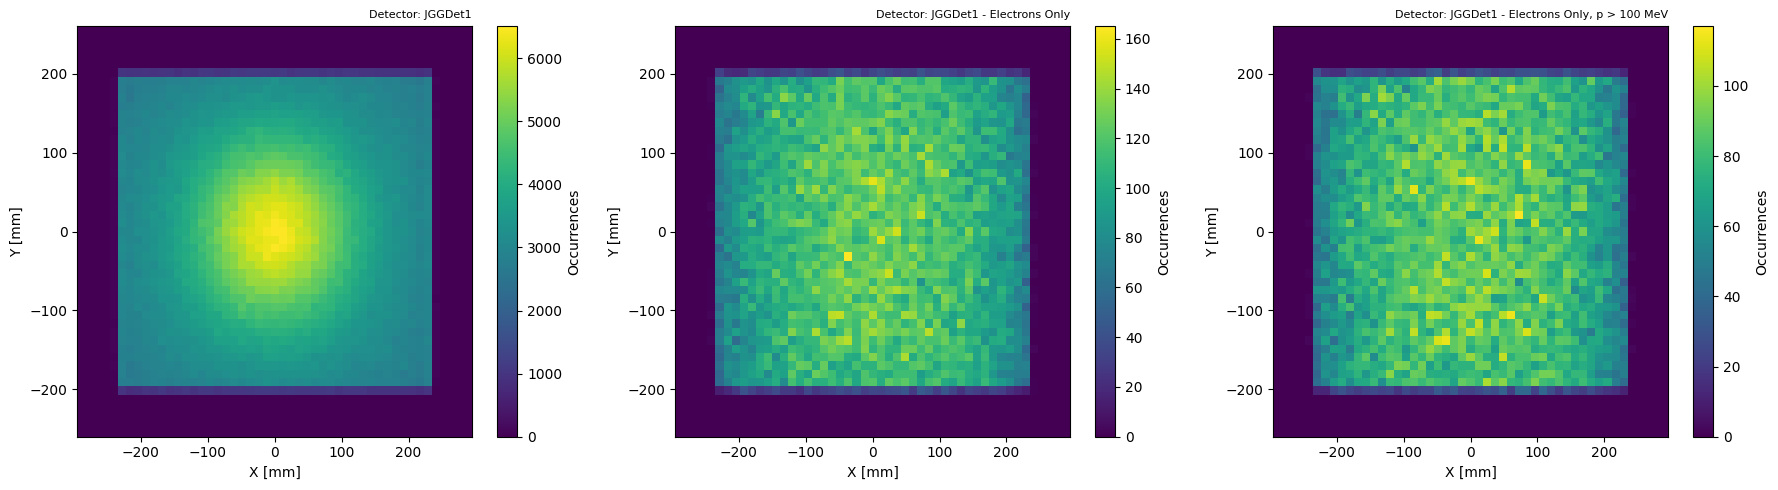

In [13]:
for det in det_list:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    def plot_2d_histogram(ax, x_data, y_data, title):
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()

        # Set bin edges dynamically with a buffer
        xedges = np.linspace(x_min - 60, x_max + 60, 50)
        yedges = np.linspace(y_min - 60, y_max + 60, 50)

        # Calculate 2D histogram
        hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=[xedges, yedges])

        # Plot the histogram with colormap
        c = ax.pcolormesh(xedges, yedges, hist.T, cmap='viridis', norm=Normalize(vmin=0, vmax=hist.max()))
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_title(title, loc='right', fontsize=8)

        # Add colorbar
        fig.colorbar(c, ax=ax, label='Occurrences')

    # Full Data
    plot_2d_histogram(ax[0], df[f'x_{det}'].values, df[f'y_{det}'].values, f'Detector: {det}')

    # Electrons Only
    x_data_e = df.query('abs(PDGid) == 11')[f'x_{det}']
    y_data_e = df.query('abs(PDGid) == 11')[f'y_{det}']
    plot_2d_histogram(ax[1], x_data_e, y_data_e, f'Detector: {det} - Electrons Only')

    # Electrons Only, p > 100 MeV
    x_data_p = df.query('abs(PDGid) == 11 and Pz_JGGDet1 > 100')[f'x_{det}']
    y_data_p = df.query('abs(PDGid) == 11 and Pz_JGGDet1 > 100')[f'y_{det}']
    plot_2d_histogram(ax[2], x_data_p, y_data_p, f'Detector: {det} - Electrons Only, p > 100 MeV')

    plt.tight_layout()
    plt.savefig(_save_dir + f'spectra_g4blsimpleT_df_pos_{config}_det{det}.jpg')
    plt.show()


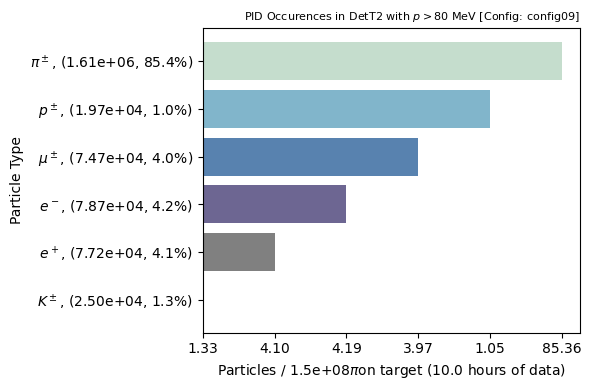

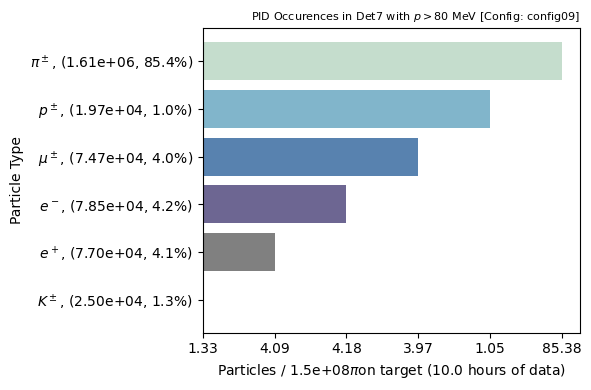

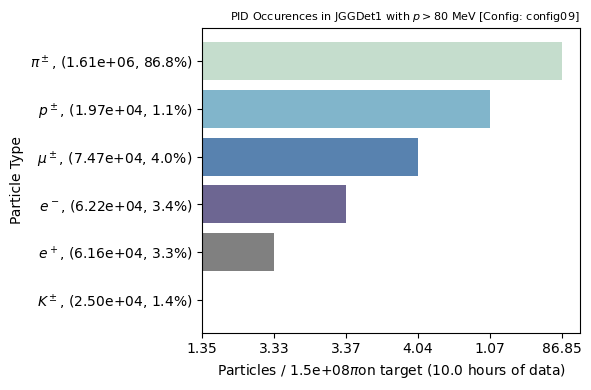

In [14]:
for det in det_list:

    values, labels = get_values_labels(df, det, 'p', 80)

    #creating a single figure for PID
    fig, ax = plt.subplots(figsize=(6,4))

    #occurences for each PID
    counts = [len(v) for v in values]
    total_count = sum(counts)

    percentages = [f'{(count / total_count) * 100:.2f}' for count in counts]

    # create bar plot with particle counts and their types
    ax.barh(labels, percentages, color=colors)

    #set labels and title 
    ax.set_xlabel(f'Particles / {n_pions:.1e}' + r'$\pi$' + f'on target ({n_hours} hours of data)')
    ax.set_ylabel('Particle Type')
    ax.set_title(f'PID Occurences in {det} with $p > {p_cut}$ MeV [Config: {config}]', loc='right', fontsize=8)

    fig.tight_layout()
    fig.savefig(_save_dir + f'pid_g4blsimpleT_df_{config}_det{det}.jpg')
    

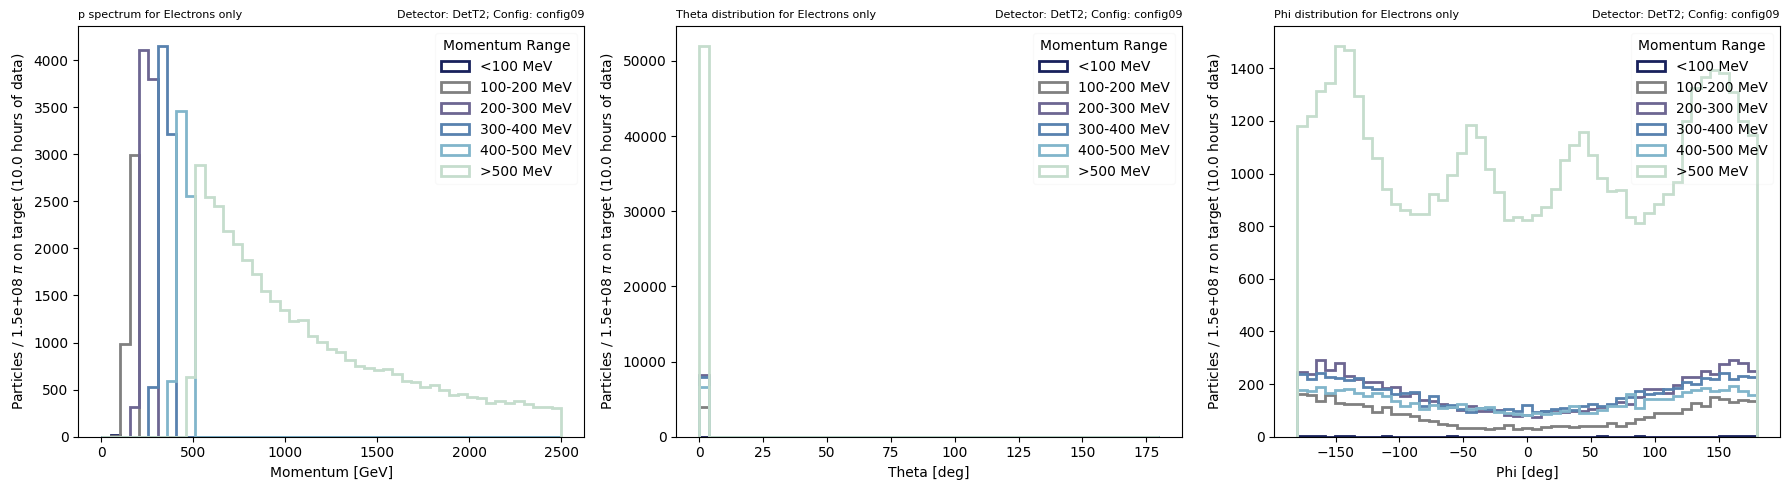

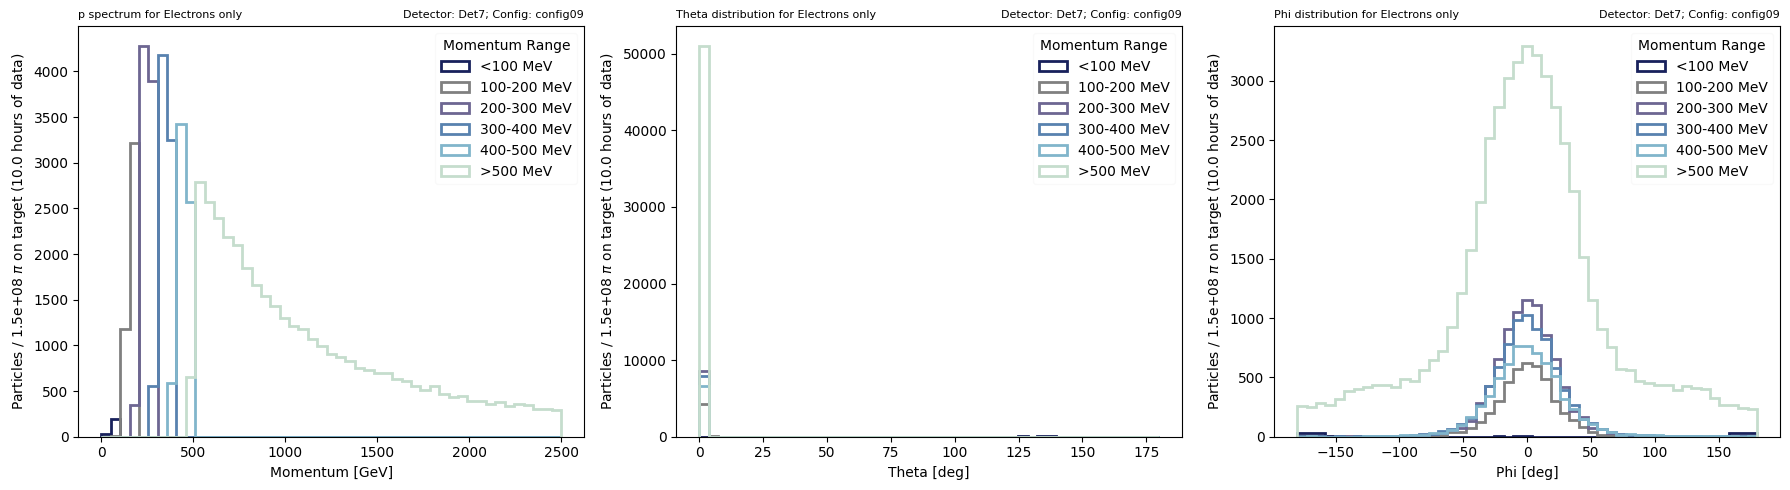

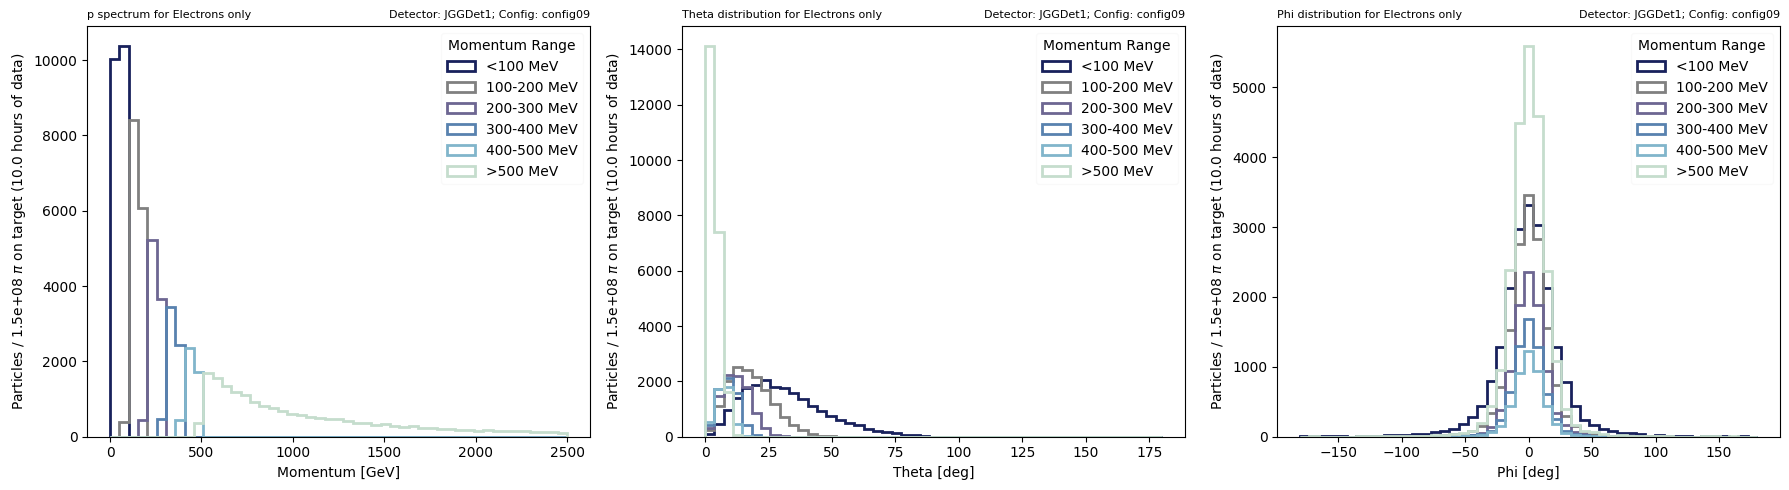

In [15]:
for det in det_list:
    
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

    # Define momentum ranges and labels
    #momentum_ranges = [(500, np.inf), (400, 500), (300, 400), (200, 300), (100, 200), (0,100)]
    #momentum_labels = ['>500 MeV','400-500 MeV','300-400 Mev','200-300 MeV','100-200 MeV','0-100 MeV']
    momentum_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, np.inf)]
    momentum_labels = ['<100 MeV', '100-200 MeV', '200-300 MeV', '300-400 MeV', '400-500 MeV', '>500 MeV']

    #colors_ = plt.cm.Set1(np.linspace(0, 1, len(momentum_ranges)))
    
    # Define axes for the histograms
    x_axis = {'p': 'Momentum [GeV]', 'theta': 'Theta [deg]', 'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50), 'theta': np.linspace(0, 180, 50), 'phi': np.linspace(-180, 180, 50)}
    
    # Filter data for pdgid = 11
    df_electrons = df[df['PDGid'] == 11]
    
    # Get values and labels for the selected detector and variable
    values, labels = get_values_labels(df_electrons, det, 'p', p_cut = 0)
    phi_values, _ = get_values_labels(df_electrons, det, 'phi', p_cut = 0)
    theta_values, _ = get_values_labels(df_electrons, det, 'theta', p_cut = 0)

    # Flatten the array of arrays, ignoring empty arrays
    flattened_values = np.concatenate([v for v in values if v.size > 0], axis=None)
    flattened_values = np.array(flattened_values, dtype=float)

    # Flatten theta values similarly
    flattened_theta_values = np.concatenate([v for v in theta_values if v.size > 0], axis=None)
    flattened_theta_values = np.array(flattened_theta_values, dtype=float)

    # Flatten phi values similarly
    flattened_phi_values = np.concatenate([v for v in phi_values if v.size > 0], axis=None)
    flattened_phi_values = np.array(flattened_phi_values, dtype=float)

    # Create stacked histograms for momentum ranges in the first subplot
    for i, ((low, high), label) in enumerate(zip(momentum_ranges, momentum_labels)):
        # Filter p values based on the current momentum range
        mask = (flattened_values >= low) & (flattened_values < high)
        filtered_values = flattened_values[mask]
        
        # Plot histograms for each momentum range
        ax[0].hist(filtered_values, bins=x_bins['p'], label=label, color=colors[i], alpha=1, histtype='step', linewidth=2)

        # Filter theta values for the same momentum range
        filtered_theta_values = flattened_theta_values[mask]
        ax[1].hist(filtered_theta_values, bins=x_bins['theta'], label=label, color=colors[i], alpha=1, histtype='step', linewidth=2)

        # Filter phi values for the same momentum range
        filtered_phi_values = flattened_phi_values[mask]
        ax[2].hist(filtered_phi_values, bins=x_bins['phi'], label=label, color=colors[i], alpha=1, histtype='step', linewidth=2)
    
    
    ax[0].set_xlabel(x_axis['p'])
    ax[0].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
    ax[0].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax[0].set_title(f'p spectrum for Electrons only', loc='left', fontsize=8)
    ax[0].legend(title='Momentum Range', loc='upper right', framealpha=0.1)
    
    ax[1].set_xlabel(x_axis['theta'])
    ax[1].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
    ax[1].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax[1].set_title(f'Theta distribution for Electrons only', loc='left', fontsize=8)
    ax[1].legend(title='Momentum Range', loc='upper right', framealpha=0.1)
    
    ax[2].set_xlabel(x_axis['phi'])
    ax[2].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
    ax[2].set_title(f'Detector: {det}; Config: {config}', loc='right', fontsize=8)
    ax[2].set_title(f'Phi distribution for Electrons only', loc='left', fontsize=8)
    ax[2].legend(title='Momentum Range', loc='upper right', framealpha=0.1)
    
    plt.tight_layout()
    plt.savefig(_save_dir + f'electron_spectra_g4blsimpleT_df_{config}_det{det}.jpg')
    plt.show()


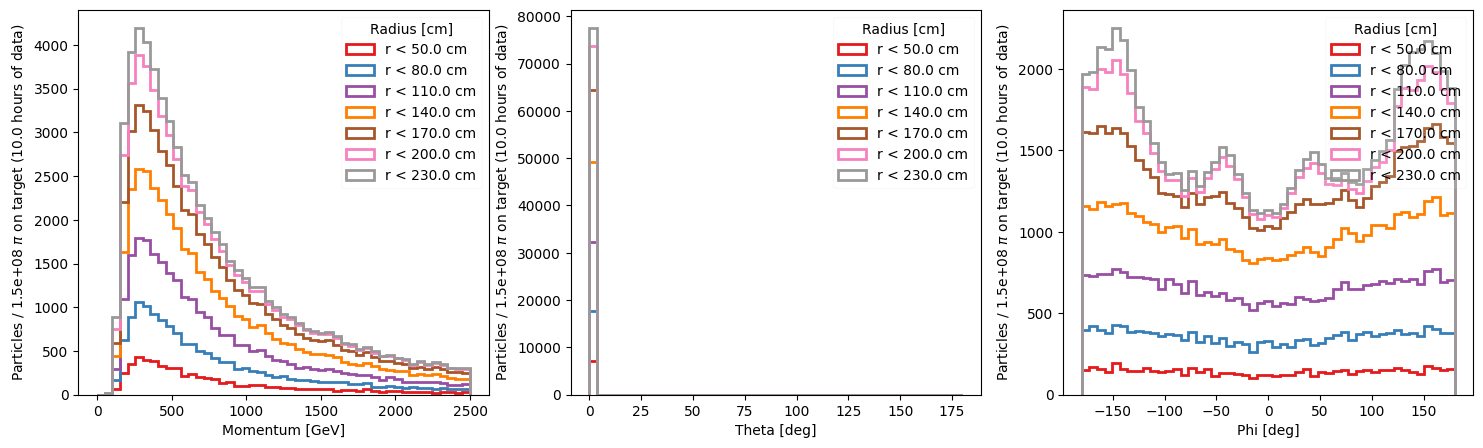

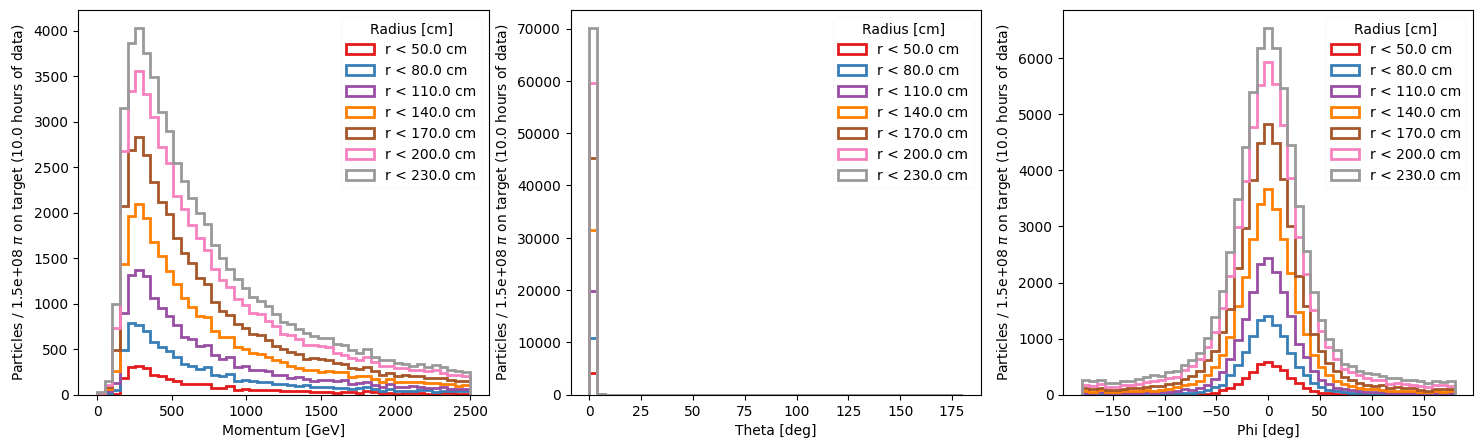

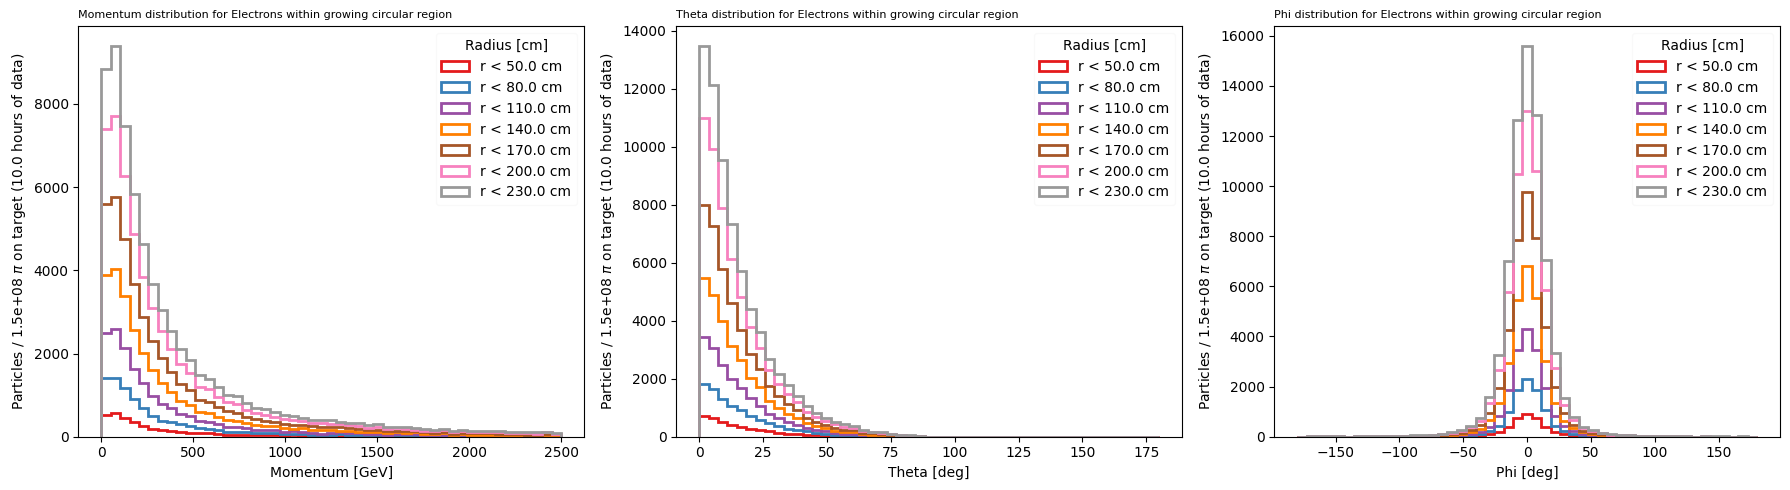

In [20]:
#circular symmetry analysis 
for det in det_list: 
    
    detector_center = (0, 0)  # (x0, y0)
    
    # Define maximum radius based on the area of the detector (DetPrime 400 * 470)
    max_radius = np.sqrt(470 * 400 / np.pi)  # cm

        # Define step size for increasing radius (e.g., 10 cm increments)
    radius_steps = np.arange(50, max_radius, 30)
    
    # Filter data for pdgid = 11 (electrons)
    df_electrons = df[df['PDGid'] == 11]
    
    # Get values for position (assuming you have 'x' and 'y' coordinates of particles)
    x_values = df_electrons[f'x_{det}'].values  # x-coordinate of particles
    y_values = df_electrons[f'y_{det}'].values  # y-coordinate of particles

     # Get values and labels for the selected detector and variable
    values, labels = get_values_labels(df_electrons, det, 'p', p_cut = 0)
    phi_values, _ = get_values_labels(df_electrons, det, 'phi', p_cut = 0)
    theta_values, _ = get_values_labels(df_electrons, det, 'theta', p_cut = 0)

    # Flatten the array of arrays, ignoring empty arrays
    flattened_values = np.concatenate([v for v in values if v.size > 0], axis=None)
    flattened_values = np.array(flattened_values, dtype=float)

    # Flatten theta values similarly
    flattened_theta_values = np.concatenate([v for v in theta_values if v.size > 0], axis=None)
    flattened_theta_values = np.array(flattened_theta_values, dtype=float)

    # Flatten phi values similarly
    flattened_phi_values = np.concatenate([v for v in phi_values if v.size > 0], axis=None)
    flattened_phi_values = np.array(flattened_phi_values, dtype=float)
    
    # Calculate the distance of each particle from the detector's center
    distances = np.sqrt((x_values - detector_center[0])**2 + (y_values - detector_center[1])**2)
    
    # Flatten the arrays for momentum, theta, and phi values
    flattened_values = np.concatenate([v for v in values if v.size > 0], axis=None)
    flattened_theta_values = np.concatenate([v for v in theta_values if v.size > 0], axis=None)
    flattened_phi_values = np.concatenate([v for v in phi_values if v.size > 0], axis=None)
    
    # Create the figure and subplots
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
    colors_ = plt.cm.Set1(np.linspace(0, 1, len(radius_steps)))
    
    # Define axes for the histograms
    x_axis = {'p': 'Momentum [GeV]', 'theta': 'Theta [deg]', 'phi': 'Phi [deg]'}
    x_bins = {'p': np.linspace(0, 2500, 50), 'theta': np.linspace(0, 180, 50), 'phi': np.linspace(-180, 180, 50)}
    
    # Loop through increasing radii and count particles inside each circle
    for i, radius in enumerate(radius_steps):
        # Filter particles within the current radius
        mask = distances <= radius
        filtered_values = flattened_values[mask]
        filtered_theta_values = flattened_theta_values[mask]
        filtered_phi_values = flattened_phi_values[mask]
        
        # Plot histograms for each variable (p, theta, phi)
        ax[0].hist(filtered_values, bins=x_bins['p'], label=f'r < {radius:.1f} cm', color=colors_[i], alpha=1, histtype='step', linewidth=2)
        ax[1].hist(filtered_theta_values, bins=x_bins['theta'], label=f'r < {radius:.1f} cm', color=colors_[i], alpha=1, histtype='step', linewidth=2)
        ax[2].hist(filtered_phi_values, bins=x_bins['phi'], label=f'r < {radius:.1f} cm', color=colors_[i], alpha=1, histtype='step', linewidth=2)
    
    # Set axis labels, titles, and legends
    for j, var in enumerate(['p', 'theta', 'phi']):
        ax[j].set_xlabel(x_axis[var])
        ax[j].set_ylabel(f'Particles / {n_pions:.1e} ' + r'$\pi$' + f' on target ({n_hours} hours of data)')
        ax[j].legend(title='Radius [cm]', loc='upper right', framealpha=0.1)

ax[0].set_title('Momentum distribution for Electrons within growing circular region', loc='left', fontsize=8)
ax[1].set_title('Theta distribution for Electrons within growing circular region', loc='left', fontsize=8)
ax[2].set_title('Phi distribution for Electrons within growing circular region', loc='left', fontsize=8)

plt.tight_layout()
#plt.savefig(_save_dir + f'electron_spectra_by_radius_df_{config}_det{det}.jpg')
plt.show()
